# Arbitrary state preparation using Model-Free Reinforcement Learning

This notebook showcases an application of the formalism introduced in PhysRevX.12.011059 (https://doi.org/10.1103/PhysRevX.12.011059) on arbitrary qubit state preparation, as depicted in the Appendix D.2b.

The implementation of the quantum environment is done here via Qiskit, calling Qiskit Runtime for the execution of parametrized quantum circuits.

Author of notebook: Arthur Strauss

Created on 11/11/2022

In [1]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment
from helper_functions import select_optimizer, generate_model

# Qiskit imports for building RL environment (circuit level)
from qiskit import IBMQ
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit_ibm_runtime import QiskitRuntimeService

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

from tf_agents.specs import array_spec, tensor_spec

# Additional imports
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

In [2]:
# IBMQ.save_account(TOKEN)
IBMQ.load_account()  # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [3]:
# Ansatz function, could be at pulse level or circuit level

def apply_parametrized_circuit(qc: QuantumCircuit):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :return:
    """
    global n_actions
    params = ParameterVector('theta', n_actions)
    qc.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], 0)
    qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], 1)
    qc.rzx(2 * np.pi * params[6], 0, 1)
    qc.u(2 * np.pi * params[7], 2 * np.pi * params[8], 2 * np.pi * params[9], 1)
    qc.u(2 * np.pi * params[10], 2 * np.pi * params[11], 2 * np.pi * params[12], 2)
    qc.rzx(2 * np.pi * params[13], 1, 2)
    

Below, we set the RL environment parameters, that is how we describe our quantum system. Below, we choose to go through the use of Qiskit Runtime, and use a simulator to get measurement outcomes based on the ansatz circuit defined above. The Environment is defined as a class object called QuantumEnvironment.

In [4]:
# If you need to overwrite the account info, please add `overwrite=True`
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="my IBM token")
service = QiskitRuntimeService(channel='ibm_quantum')
seed = 3590  # Seed for action sampling
backend = service.backends(simulator=True)[0]  # Simulation backend (mock quantum computer)
options = {"seed_simulator": None, 'resilience_level': 0}
n_qubits = 3
sampling_Paulis = 50 # Define how many observables we shall sample in Pauli space
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector and each observable 
n_actions = 14  # Choose how many control parameters in pulse/circuit parametrization
time_steps = 1  # Number of time steps within an episode (1 means you do one readout and assign right away the reward)

action_spec = tensor_spec.BoundedTensorSpec(shape=(n_actions,), dtype=tf.float32, minimum=-1., maximum=1.)
observation_spec = array_spec.ArraySpec(shape=(time_steps,), dtype=np.int32)

Qiskit_setup = {
    "backend": backend,
    "service": service,
    "parametrized_circuit": apply_parametrized_circuit,
    "options": options
}

print('backend for quantum system:', backend)


backend for quantum system: <IBMBackend('ibmq_qasm_simulator')>


In [5]:
# Define here target state density matrix

# Target state: GHZ state
ket0, ket1 = np.array([[1.], [0]]), np.array([[0.], [1.]])
ket000, ket111 = np.kron(np.kron(ket0, ket0), ket0), np.kron(np.kron(ket1, ket1), ket1)
GHZ_state = (ket000 + ket111) / np.sqrt(2)
GHZ_dm = GHZ_state @ GHZ_state.conj().T
target_state = {"dm": DensityMatrix(GHZ_dm)}
print("Target state Density matrix:", target_state)

Target state Density matrix: {'dm': DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j]],
              dims=(2, 2, 2))}


In [9]:
# Declare QuantumEnvironment variable

q_env = QuantumEnvironment(n_qubits=n_qubits, target=target_state, abstraction_level="circuit",
                           action_spec=action_spec, observation_spec=observation_spec,
                           Qiskit_config=Qiskit_setup,
                           sampling_Pauli_space=sampling_Paulis, n_shots=N_shots, c_factor=1.)
print(q_env.target)

{'dm': DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j]],
              dims=(2, 2, 2)), 'Chi': array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0., 

We now define the Agent, which will be in general a Deep Neural Network.
We start by defining the hyperparameters of the training

In [10]:
# Hyperparameters for the agent
n_epochs = 1500  # Number of epochs
batchsize = 200  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
opti = "Adam"
eta = 0.001  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.2  # Parameter for clipping value (PPO)
grad_clip = 0.1
critic_loss_coeff = 0.5
optimizer = select_optimizer(lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2)
sigma_eps = 1e-3  # for numerical stability


In [11]:
# Policy parameters: generate NN that will output mean and variances of the policy

# Policy parameters
N_in = n_qubits + 1  # One input for each measured qubit state (0 or 1 input for each neuron)
hidden_units = [100, 100, 100]  # List containing number of units in each hidden layer

network = generate_model((N_in,), hidden_units, n_actions, actor_critic_together=True)
network.summary()
init_msmt = np.zeros((1, N_in))  # Here no feedback involved, so measurement sequence is always the same

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 100)          500         input_1[0][0]                    
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 100)          10100       hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 100)          10100       hidden_1[0][0]                   
______________________________________________________________________________________________

2023-02-01 10:51:35.470294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Plotting tools
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 20
%matplotlib inline

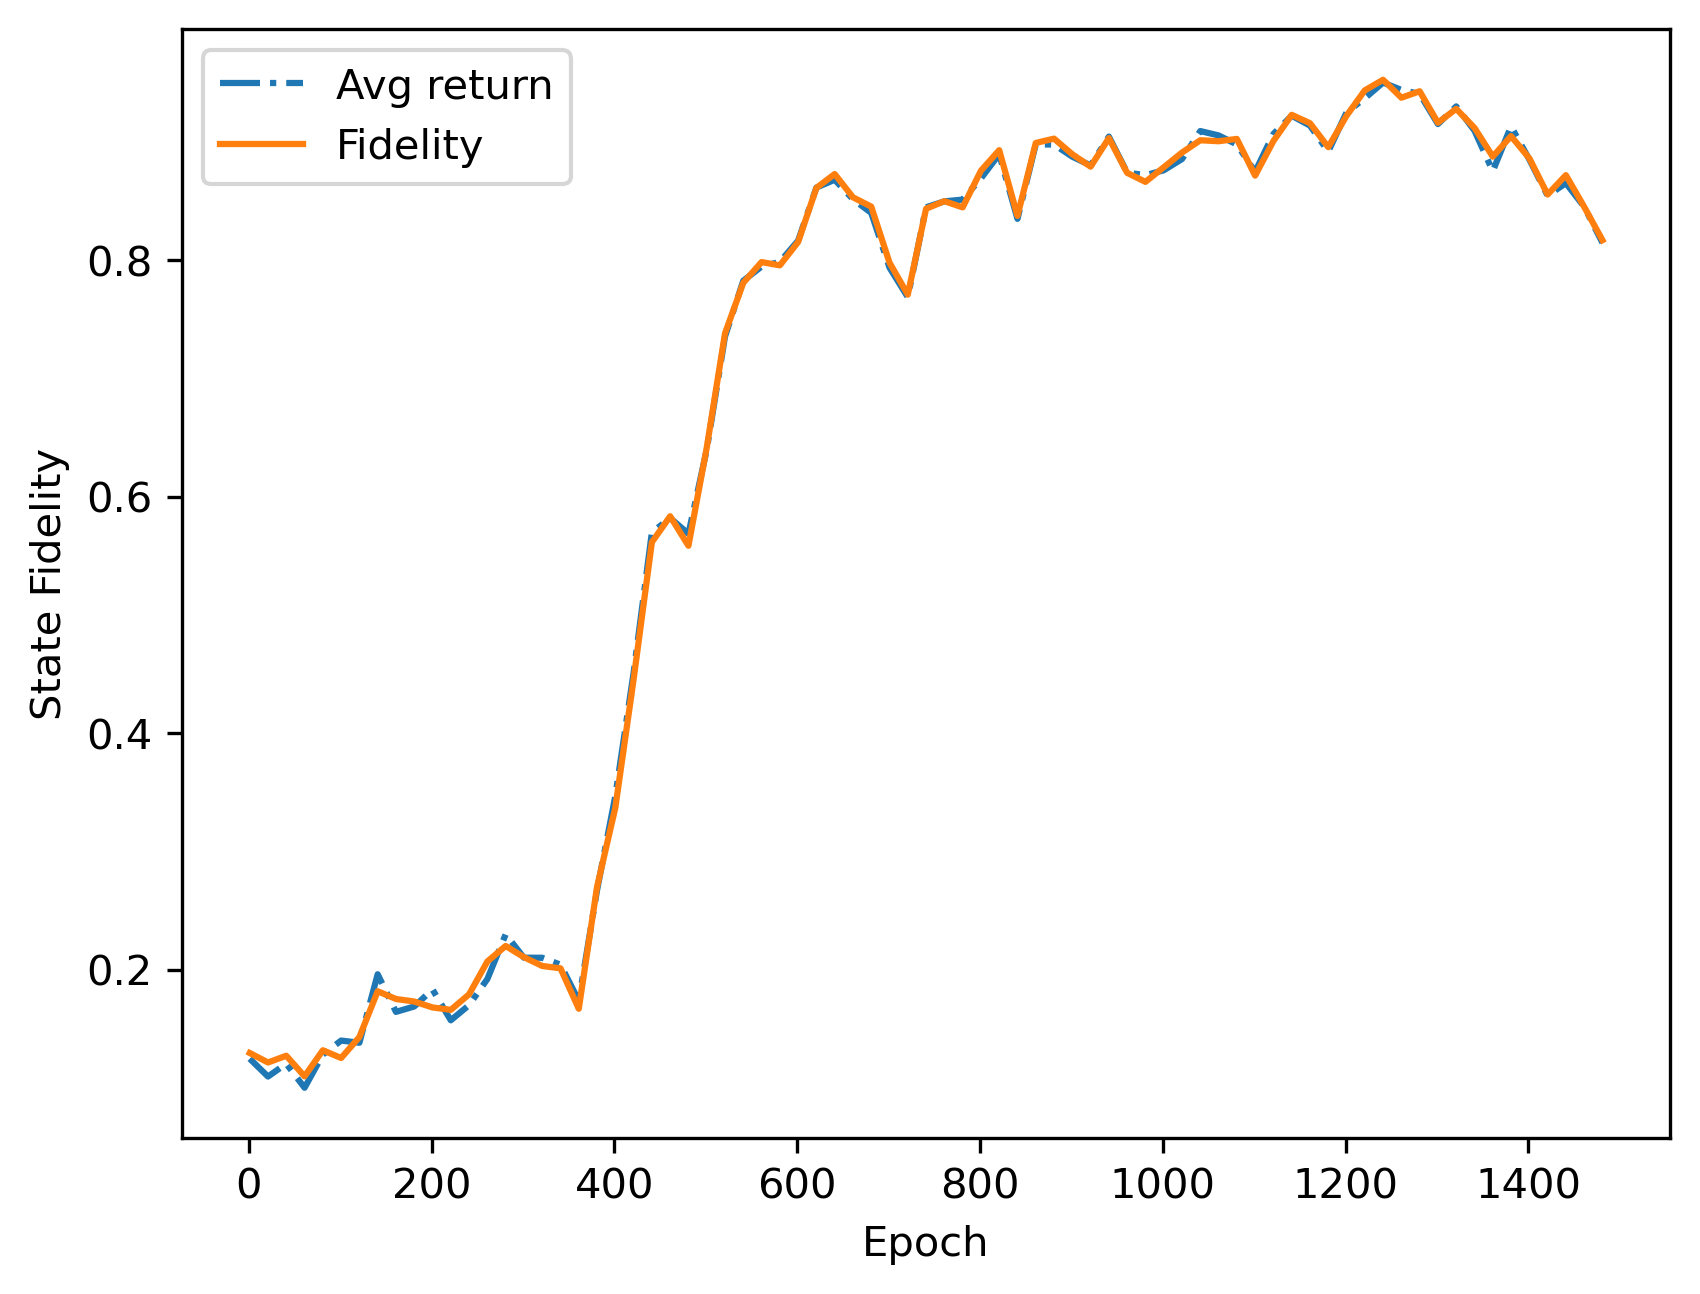

 99%|████████████████████████████████████▌| 1481/1500 [1:06:11<00:50,  2.66s/it]

Maximum fidelity reached so far: 0.9626419465157767


 99%|████████████████████████████████████▌| 1482/1500 [1:06:13<00:47,  2.64s/it]

Fidelity 0.8287242642579593


 99%|████████████████████████████████████▌| 1483/1500 [1:06:16<00:44,  2.60s/it]

Fidelity 0.8313726800703205


 99%|████████████████████████████████████▌| 1484/1500 [1:06:18<00:41,  2.58s/it]

Fidelity 0.8349539045389397


 99%|████████████████████████████████████▋| 1485/1500 [1:06:21<00:37,  2.50s/it]

Fidelity 0.8427338098443266


 99%|████████████████████████████████████▋| 1486/1500 [1:06:23<00:34,  2.47s/it]

Fidelity 0.8140194671020242


 99%|████████████████████████████████████▋| 1487/1500 [1:06:25<00:31,  2.45s/it]

Fidelity 0.8240441313841977


 99%|████████████████████████████████████▋| 1488/1500 [1:06:29<00:31,  2.66s/it]

Fidelity 0.8039870571143806


 99%|████████████████████████████████████▋| 1489/1500 [1:06:31<00:27,  2.54s/it]

Fidelity 0.8027673936787312


 99%|████████████████████████████████████▊| 1490/1500 [1:06:33<00:24,  2.50s/it]

Fidelity 0.7869252666462726


 99%|████████████████████████████████████▊| 1491/1500 [1:06:36<00:22,  2.46s/it]

Fidelity 0.7997940334220804


 99%|████████████████████████████████████▊| 1492/1500 [1:06:38<00:19,  2.44s/it]

Fidelity 0.7968904155557267


100%|████████████████████████████████████▊| 1493/1500 [1:06:40<00:16,  2.38s/it]

Fidelity 0.8028937486175466


100%|████████████████████████████████████▊| 1494/1500 [1:06:43<00:14,  2.38s/it]

Fidelity 0.8073674301423445


100%|████████████████████████████████████▉| 1495/1500 [1:06:45<00:11,  2.39s/it]

Fidelity 0.8140022441525913


100%|████████████████████████████████████▉| 1496/1500 [1:06:47<00:09,  2.38s/it]

Fidelity 0.8308509808754214


100%|████████████████████████████████████▉| 1497/1500 [1:06:50<00:07,  2.34s/it]

Fidelity 0.8375518483449543


100%|████████████████████████████████████▉| 1498/1500 [1:06:52<00:04,  2.34s/it]

Fidelity 0.8419328949121756


100%|████████████████████████████████████▉| 1499/1500 [1:06:54<00:02,  2.37s/it]

Fidelity 0.8404133085726578


100%|█████████████████████████████████████| 1500/1500 [1:06:57<00:00,  2.68s/it]

Fidelity 0.8430243207748133


In [14]:
# Training loop 

mu_old = tf.Variable(initial_value=network(init_msmt)[0][0], trainable=False)
sigma_old = tf.Variable(initial_value=network(init_msmt)[1][0], trainable=False)

policy_params_str = 'Policy params:'

for i in tqdm(range(n_epochs)):

    Old_distrib = MultivariateNormalDiag(loc=mu_old, scale_diag=sigma_old,
                                         validate_args=True, allow_nan_stats=False)

    with tf.GradientTape(persistent=True) as tape:

        mu, sigma, b = network(init_msmt, training=True)
        mu = tf.squeeze(mu, axis=0)
        sigma = tf.squeeze(sigma, axis=0)
        b = tf.squeeze(b, axis=0)

        Policy_distrib = MultivariateNormalDiag(loc=mu, scale_diag=sigma,
                                                validate_args=True, allow_nan_stats=False)

        action_vector = tf.stop_gradient(tf.clip_by_value(Policy_distrib.sample(batchsize), -1., 1.))

        reward = q_env.perform_action(action_vector)
        advantage = reward - b

        if use_PPO:
            ratio = Policy_distrib.prob(action_vector) / (tf.stop_gradient(Old_distrib.prob(action_vector)) + 1e-7)
            actor_loss = - tf.reduce_mean(tf.minimum(advantage * ratio,
                                                     advantage * tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)))
        else:  # REINFORCE algorithm
            actor_loss = - tf.reduce_mean(advantage * Policy_distrib.log_prob(action_vector))

        critic_loss = tf.reduce_mean(advantage ** 2)
        combined_loss = actor_loss + critic_loss_coeff * critic_loss

    grads = tape.gradient(combined_loss, network.trainable_variables)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.assign(mu)
        sigma_old.assign(sigma)
    avg_return[i] = np.mean(q_env.reward_history, axis =1)[i]
    fidelities[i] = q_env.state_fidelity_history[i]
    print("Fidelity", fidelities[i])
    if i%visualization_steps == 0:
        clear_output(wait=True) # for animation
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, n_epochs, 20),avg_return[0:-1:visualization_steps], '-.', label='Avg return')
        ax.plot(np.arange(1, n_epochs, 20),fidelities[0:-1:visualization_steps], label='Fidelity')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("State Fidelity")
        ax.legend()
        plt.show()
        print("Maximum fidelity reached so far:", np.max(fidelities))
        

    # Apply gradients
    optimizer.apply_gradients(zip(grads, network.trainable_variables))

In [15]:
print("Maximum fidelity reached:", np.max(fidelities), 'at Epoch ', np.argmax(fidelities))

Maximum fidelity reached: 0.9626419465157767 at Epoch  1237
